<a href="https://colab.research.google.com/github/AlbertoCampini/AAUT/blob/master/AdaBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import math
from copy import deepcopy
import sklearn.datasets
from sklearn.svm import SVC

# Dataset

We import the dataset from Hastie & Tibshirani book. 
This is an artificially generated binary classification problem. Labels are in the set $\{-1,+1\}$.

In [ ]:
X,y = sklearn.datasets.make_hastie_10_2()
X_train = X[0:8000,:]
y_train = y[0:8000]
X_test = X[8000:,:]
y_test = y[8000:]

# Adaboost implementation

Here we implement the Adaboost algorith. We shall assume that:
- that the problem is a binary classification problem with labels in $\{-1, +1\}$.
- that the weakModel can fit a weighted sample set by means of the call `weakModel.fit(X,y,sample_weight=w)` where `w` is a vector of length $n=|X|=|y|$.

In [ ]:
class AdaBoost:
    def __init__(self, weakModel, T):
        self.T=T
        self.weakModel=weakModel
        self.classifiers=[]
        self.alphas=[]
        self.wl_errors=[]
        self.ens_errors=[]

    def train_weak_model(self,X,y,w):
         result=deepcopy(self.weakModel)
         result.fit(X,y,sample_weight=w)
         return result      
    def weighted_error(self, y,y_,w):
         return np.sum(w[y!=y_])
    def fit(self, X, y):
        n=len(y)
        w=np.ones(n)/n

        ensamble_pred=np.zeros(n)
        for t in range(self.T):
          mt= self.train_weak_model(X,y,w)
          y_=mt.predict(X)
          error=self.weighted_error(y,y_,w)
          if(error>=0.5):
            raise ValueError("Weak Learner failed")
          alpha_t=0.5*math.log((1-error)/error)
          self.classifiers.append(mt)
          self.alphas.append(alpha_t)



          w = w* np.exp(-alpha_t*y*y_)
          w = w / np.sum(w)


          ensamble_pred += alpha_t*y_
          enamble_err = np.sum(np.sign(ensamble_pred)!=y)/n
          self.ens_errors.append(enamble_err)
          self.wl_errors.append(error)

          if t>1 and t%10==0:
              print(f"step{t} et {error} ensambleError {enamble_err}")
        return self

    def predict(self, X):
        predictions=np.array([cl.predict(X) for cl in self.classifiers])
        return np.sign(np.array(self.alphas).dot(predictions))

# Testing with an SVM

Let us now see how our iplementation of AdaBoost performs on the dataset we loaded above. In this experiment we want the weak learning algorithm $\mathcal{A}$ to be good, but not too much. An SVM with a polynomial kernel of degre 3 works fine for our needs.

The SVC implementation provided by sklearn does not work well when weights are normalized. The following code simply "denormalize" weights befor calling into SVC implementation.

In [ ]:
    class SVC_:
        def __init__(self, kernel="rbf", degree="3"):
            self.svc = SVC(kernel=kernel, degree=degree)

        def fit(self, X,y,sample_weight=None):
            if sample_weight is not None:
                sample_weight = sample_weight * len(X)

            self.svc.fit(X,y,sample_weight=sample_weight)
            return self

        def predict(self, X):
            return self.svc.predict(X)

In [ ]:
weakModel = SVC_(kernel="poly", degree=3)
adaboost = AdaBoost(weakModel, 100).fit(X_train,y_train)
y_train_ = adaboost.predict(X_train)
y_test_ = adaboost.predict(X_test)

step10 et 0.37791670430095603 ensableerror 0.21325
step20 et 0.4009203786340835 ensableerror 0.169125
step30 et 0.42197274291187586 ensableerror 0.15375
step40 et 0.44068639350885697 ensableerror 0.14675
step50 et 0.45625595429133253 ensableerror 0.14675
step60 et 0.46262572191993645 ensableerror 0.138
step70 et 0.4456646437694925 ensableerror 0.136875
step80 et 0.456008744671691 ensableerror 0.131875
step90 et 0.46559769547841434 ensableerror 0.12825


In [ ]:
sum(y_test==y_test_)/len(y_test)

0.8375

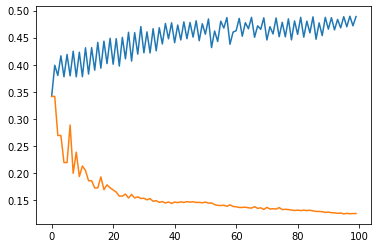

In [ ]:
import matplotlib.pyplot as plt

plt.plot(adaboost.wl_errors, label="eps")
plt.plot(adaboost.ens_errors, label="ens")


# Testing on the weakest of the weak learners

We now want to experiment with a VERY weak learner. The weak learner works as follows:

- it creates a random linear model by generating the needed weight vector $\mathbf{w}$ at random; each weight shall be sampled from U(-1,1);
- it evaluates the weighted loss $\epsilon_t$ on the given dataset and flip the linear model if $\epsilon_t > 0.5$
- at prediction time it predicts +1 if $\mathbf{x} \cdot \mathbf{w} > 0$ it predicts -1 otherwise.

In [ ]:
class RandomLinearModel:
    def loss(self, y, y_, w):
        return np.sum(w[y!=y_])
        
    def fit(self,X,y,sample_weight=None):
        self.colWeight=(np.random.rand(X.shape[1]) -.5)*2.0 
        y_=self.predict(X)
        if(self.loss(y,y_,sample_weight)>=0.5):
          self.colWeight=-self.colWeight
        return self

    def predict(self,X):
        return np.sign(X @ self.colWeight)

Let us now learn an AdaBoost model using the RandomLinearModel weak learner printing every $K$ iterations the weighted error and the current error of the ensemble. Evaluate the training and test error of the final ensemble model.

In [ ]:
rs = RandomLinearModel()
a = AdaBoost(rs,30000)
a.fit(X_train,y_train)

y_train_ = a.predict(X_train)
y_test_ = a.predict(X_test)

In [ ]:
print(sum(y_test==y_test_)/len(y_test))
print(sum(y_train==y_train_)/len(y_train))

0.51875
0.960375


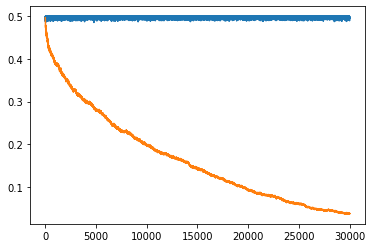

In [ ]:
import matplotlib.pyplot as plt

plt.plot(a.wl_errors, label="eps")
plt.plot(a.ens_errors, label="ens")
